In [31]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

In [59]:



import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import re
import collections
import string
from collections import OrderedDict
import random
from collections import Counter
import statistics
num_regex = re.compile(r'\d+')
import os
import operator

t_4200 = 4200.0
sigma99 = '0.56003'
sigma95 = '1.00180'
sigma90 = '1.51378'
pc_sigma_pair_99 = (99, sigma99)
pc_sigma_pair_95 = (95, sigma95)
pc_sigma_pair_90 = (90, sigma90)

#dates of the runs performed
dates99 = ['-20-August-2019', '-12-September-2019', '-20-September-2019']
dates95 = ['-20-August-2019', '-12-September-2019']
dates90 = ['-20-August-2019']

In [60]:
def getDictOfRunCounters(sigma, percent, date='', runID_padder=0):
    '''returns a dict of dicts with the run ID being the key and the items being a dict of the counters
    
    the runID_padder is an integer that adds onto the runIDs of a file, so successive runs from different dates 
    can be combined into a master dict of all the runs
    
    this method now also returns the no. of runs in the file, used to pad the next one'''
    
    filename = 'counters_data/all_run_populations-'+str(percent)+'_suscep'+date+'/pyrithione-t=4200.0-parallel-event_counters_sigma='+str(sigma)+'.txt'
    runID_dict = {}
    
    with open(filename) as infile:
        reader = csv.reader(infile, delimiter=',')
        
        first_line = next(reader)
        idKey_prefix = first_line[0].replace('#', '').strip()
        counter_keys = [ck.strip() for ck in first_line[1:]]
        
        for line in reader:
            
            counter_dict = {}
            for ck, c_val in zip(counter_keys, line[1:]):
                counter_dict[ck] = float(c_val.strip())
            
            runID_val = int(line[0])+runID_padder
            runID_key = idKey_prefix+' = '+str(runID_val)
            runID_dict[runID_key] = counter_dict
            
    return runID_dict, len(runID_dict)


In [61]:
#dicts of all the event counters

eventCounters_99pc_20Aug2019, nruns_99pc_20Aug2019 = getDictOfRunCounters(sigma99, 99, dates99[0])
eventCounters_99pc_12Sep2019, nruns_99pc_12Sep2019 = getDictOfRunCounters(sigma99, 99, dates99[1], nruns_99pc_20Aug2019)
eventCounters_99pc_20Sep2019, nruns_99pc_20Sep2019 = getDictOfRunCounters(sigma99, 99, dates99[2], nruns_99pc_12Sep2019)
eventCounters_99pc_ALL = eventCounters_99pc_20Aug2019.copy()
eventCounters_99pc_ALL.update(eventCounters_99pc_12Sep2019)
eventCounters_99pc_ALL.update(eventCounters_99pc_20Sep2019)
#print(eventCounters_99pc_ALL.keys())

eventCounters_95pc_20Aug2019, nruns_95pc_20Aug2019 = getDictOfRunCounters(sigma95, 95, dates95[0])
eventCounters_95pc_12Sep2019, nruns_95pc_12Sep201 = getDictOfRunCounters(sigma95, 95, dates95[0])
eventCounters_95pc_ALL = eventCounters_95pc_20Aug2019.copy()
eventCounters_95pc_ALL.update(eventCounters_95pc_12Sep2019)


eventCounters_90pc_20Aug2019, nruns_90pc_20Aug2019 = getDictOfRunCounters(sigma90, 90, dates[0])

In [35]:
#lists of the padders for the runIDs. pretty redundant, but useful in case we ever change the no. of runs in a simulation
runID_padders_99pc = [0, nruns_99pc_20Aug2019, nruns_99pc_12Sep2019]
runID_padders_95pc = [0, nruns_95pc_20Aug2019]
runID_padders_90pc = [0]

In [36]:
def getDictOfPopDistbsAtEachTime(sigma, duration, percent, date, runID):
    #this returns a dict containing dicts of each microhab's populations at each timestep
    
    filename = 'counters_data/all_run_populations-'+str(percent)+'_suscep'+str(date)+'/pyrithione-t='+str(duration)+'-sigma='+str(sigma)+'-mh_pops-runID='+str(runID)+'.txt'
    timestep_dict = {}
    
    with open(filename) as infile:
        reader = csv.reader(infile, delimiter=",")

        for row in reader:
            
            if row[0].startswith('#'):
                t_val = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", row[0][:])[0]
                t_val = (float((t_val)))
                timekey = 't = '+'{:.1f}'.format(t_val)
                timestep_dict[timekey] = {}
                mh_index = 0
                
            else:
                if all(float(x) > 0 for x in row): mh_pop = [float(col.strip()) for col in row]
                else: mh_pop = []
                mh_key = 'mh = '+str(mh_index)
                timestep_dict[timekey][mh_key] = mh_pop
                mh_index += 1
          
                
    return timestep_dict


def getDictOfPopDistbsAtEachTime_filename(file_name):
    #this returns a dict containing dicts of each microhab's populations at each timestep
    
    filename = file_name
    timestep_dict = {}
    
    with open(filename) as infile:
        reader = csv.reader(infile, delimiter=",")

        for row in reader:
            
            if row[0].startswith('#'):
                t_val = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", row[0][:])[0]
                t_val = (float((t_val)))
                timekey = 't = '+'{:.1f}'.format(t_val)
                timestep_dict[timekey] = {}
                mh_index = 0
                
            else:
                if all(float(x) > 0 for x in row): mh_pop = [float(col.strip()) for col in row]
                else: mh_pop = []
                mh_key = 'mh = '+str(mh_index)
                timestep_dict[timekey][mh_key] = mh_pop
                mh_index += 1
          
                
    return timestep_dict

In [37]:
def plotGenosInMicroHabOverTime(geno_dict, mh_index, counter_dict, runID, percent):
    #geno_dict is the big dict that has the pop distbs with the times as keys
    #time_key = 't = 0'
    rando = lambda: random.randint(0,255)
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 12
    legendsize = 10
    IDsize=12
    
    percent_res = 100 - percent
    
    mh_key = 'mh = '+str(mh_index)
    color_dict = {}
    
    #this gets most resistant genotype in the geno_dict, used to compare for colour intensity
    max_geno_val = 0
    for t in geno_dict:
        for mh in geno_dict[t]:
            if len(geno_dict[t][mh]): 
                if max(geno_dict[t][mh]) > max_geno_val: max_geno_val = max(geno_dict[t][mh])
    
    
    #this sorted thing gets a list of the time keys sorted numerically
    #the regex removes all letters
    for time_key in sorted(geno_dict, key = lambda x: float(re.sub("\D", "", x)))[::]:
    
        geno_counts = dict(Counter(geno_dict[time_key][mh_key])) #gets the counts for each genotype
        geno_counts = dict(sorted(geno_counts.items())) #sorts them so least resistant at bottom
        
        bar_ypos = 0
        #geno_key is the numeric value of that genotype
        for geno_key, geno_count in sorted(geno_counts.items()):
            #this gives the number of each genotype present, from least resistant to most
            
            #allows for an arbitrary number of distinct colours to be used to label the genotypes
            #cast to int to group similar genos together, to take up less space on legend
            grouped_geno_key = int(geno_key)
            if grouped_geno_key in color_dict:
                geno_colour = color_dict[grouped_geno_key]
            else:
                geno_colour = '#%02X%02X%02X' % (rando(),rando(),rando())
                color_dict[grouped_geno_key] = geno_colour
                
            
            percent_of_max_r = grouped_geno_key/max_geno_val
            geno_colour2 = (percent_of_max_r, 0.3*percent_of_max_r, 0.42)
            
            #t = int(re.sub("\D", "", time_key))
            t = float(re.findall("\d+\.\d+", time_key)[0])
            #print(time_key)
            #print(t)
            ax.bar(x=t, height=geno_count, bottom=bar_ypos, color=geno_colour2, width=42, label=(grouped_geno_key))
            bar_ypos += geno_count
            
        
    #plt.xticks(x_indices, x_labels, fontsize=20, rotation = 45)
    ax.set_ylabel('n bacteria', fontsize=labelSize)
    ax.set_xlabel('time (hours)', fontsize=labelSize)
    ax.tick_params(axis="x", labelsize=numbersize)
    ax.tick_params(axis="y", labelsize=numbersize)
    
    #convert labels to numbers, order them alongside the handles, then reconvert to strings
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [int(x) for x in labels]
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    labels = [str(x) for x in labels]
    #remove duplicate labels
    by_label = OrderedDict(zip(labels, handles))
    by_label = OrderedDict(reversed(list(by_label.items())))
    
    plt.title(str(percent_res)+'% resistant,    '+'mh: '+str(mh_index)+'    run: '+str(runID)+'    replications: '+counter_dict['n_replications'], fontsize=titleSize)
    
    plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.02,0.8), fontsize='large', ncol=3)
    plt.savefig('counters_data/all_run_populations_testing/test_geno_output.pdf', bbox_inches='tight')
    plt.show()


In [38]:
def plotGenosInSystemOverTime(geno_dict, counter_dict, runID, percent, date):
    #geno_dict is the big dict that has the pop distbs with the times as keys
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 12
    legendsize = 10
    IDsize=12
    
    percent_res = 100 - percent
    
    #this is averaging stuff used for diagnostics
    pop_counts = []
    for tk in geno_dict:
        for mk in geno_dict[tk]:
        
            pop_counts.append(len(geno_dict[tk][mk]))
        
    avg_N = (sum(pop_counts)/len(pop_counts))
    
    #this gets most resistant genotype in the geno_dict, used to compare for colour intensity
    max_geno_val = 0
    for t in geno_dict:
        for mh in geno_dict[t]:
            if len(geno_dict[t][mh]): 
                if max(geno_dict[t][mh]) > max_geno_val: max_geno_val = max(geno_dict[t][mh])
                    
                    
    #this sorted thing gets a list of the time keys sorted numerically
    #the regex removes all letters
    for time_key in sorted(geno_dict, key = lambda x: float(re.sub("\D", "", x)))[::]:
        
        bar_ypos = 0
        
        for mh_key in sorted(geno_dict[time_key], key = lambda x: float(re.sub("\D", "", x)))[::]:
        
            #if '1' in mh_key: print(time_key)
    
            geno_counts = dict(Counter(geno_dict[time_key][mh_key])) #gets the counts for each genotype
            geno_counts = dict(sorted(geno_counts.items())) #sorts them so least resistant at bottom
        
        
            #geno_key is the numeric value of that genotype
            for geno_key, geno_count in sorted(geno_counts.items()):
                #this gives the number of each genotype present, from least resistant to most
            
                #allows for an arbitrary number of distinct colours to be used to label the genotypes
                #cast to int to group similar genos together, to take up less space on legend
                grouped_geno_key = int(geno_key)
                percent_of_max_r = grouped_geno_key/max_geno_val
                geno_colour = (percent_of_max_r, 0.3*percent_of_max_r, 0.42)
            
                t = float(re.findall("\d+\.\d+", time_key)[0])
                #print(time_key)
                #print(t)
                ax.bar(x=t, height=geno_count, bottom=bar_ypos, color=geno_colour, width=42, label=(grouped_geno_key))
                bar_ypos += geno_count
            
    ax.set_ylabel('n bacteria', fontsize=labelSize)
    ax.set_xlabel('time (hours)', fontsize=labelSize)
    ax.tick_params(axis="x", labelsize=numbersize)
    ax.tick_params(axis="y", labelsize=numbersize)
    
    
    
    #convert labels to numbers, order them alongside the handles, then reconvert to strings
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [int(x) for x in labels]
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    labels = [str(x) for x in labels]
    #remove duplicate labels
    by_label = OrderedDict(zip(labels, handles))
    by_label = OrderedDict(reversed(list(by_label.items())))
    
    #ax.axhline(avg_N, linewidth=5, label='avg N = '+str(avg_N))
    
    #plt.title(str(percent_res)+'% resistant,    '+'run: '+str(runID)+'    replications: '+counter_dict['n_replications']+' avg N = '+str(avg_N), fontsize=titleSize)
    plt.title(str(percent_res)+'% resistant,    '+'run: '+str(runID)+'    replications: '+str(counter_dict['n_replications']), fontsize=titleSize)
    plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.02,0.8), fontsize='large', ncol=3)
    plt.savefig('counters_plots/all_run_populations_'+str(percent)+'/allGenos_runID='+str(runID)+date+'.pdf', bbox_inches='tight')
    plt.show()
    


In [39]:
def plotAvgGenoVsDistance(geno_dict, runID, percent, date):
    '''this plots the average genotype value in each microhabitat as a function of distance.  each curve 
    plotted is another time value'''
    
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    percent_res = 100 - percent
    
    time = '4200.0'
    tk = 't = '+time
    avg_genos = []
    geno_stdevs = []
    microhabitats = []
    
    #iterate through all microhabitats at a given time
    for mh in geno_dict[tk]:
        avg_genos.append(statistics.mean(geno_dict[tk][mh]))
        geno_stdevs.append(statistics.stdev(geno_dict[tk][mh]))
        microhabitats.append([int(s) for s in mh.split() if s.isdigit()][0])
    
    
    ax.set_ylabel('genotype', fontsize=labelSize)
    ax.set_xlabel('distance', fontsize=labelSize)
    ax.tick_params(axis="x", labelsize=numbersize)
    ax.tick_params(axis="y", labelsize=numbersize)
    
    plt.title('avg genotype vs distance ('+str(percent_res)+'% resistant,  '+'run: '+str(runID)+')', fontsize=titleSize)
    ax.errorbar(microhabitats, avg_genos, yerr=geno_stdevs)
    
    plt.savefig('counters_plots/all_run_populations_'+str(percent)+'/avg_geno_vs_distance-runID='+str(runID)+str(date)+'.pdf', bbox_inches='tight')
    plt.show()
    

In [40]:
date = '-20-August-2019'
percent, sigma = pc_sigma_pair_95
runID = 52


all_counters,_ = getDictOfRunCounters(sigma=sigma, percent=percent, date=date)
run_conters = all_counters['run_ID = '+str(runID)]
geno_dict = getDictOfPopDistbsAtEachTime(sigma, t_4200, percent, date, runID)
#print(geno_dict['t = 4200.0'])


#all_counters = getDictOfRunCounters(sigma=sigma, percent=percent, date=date)
#run_counters = all_counters['run_ID = '+str(runID)]
#geno_dict = getDictOfPopDistbsAtEachTime(sigma, '2048.0', 'testing', runID)
#tk = 't = 389.1'
#for mh_key in geno_dict[tk]:
#    print(len(geno_dict[tk][mh_key]))
#    print()

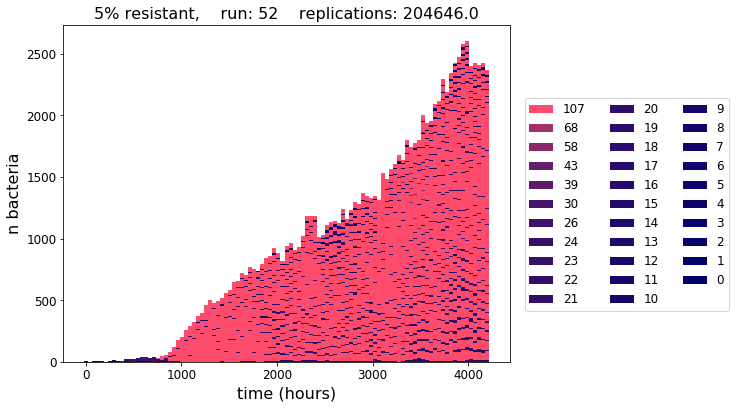

In [41]:
plotGenosInSystemOverTime(geno_dict, run_conters, runID, percent, date)
#plotGenosInMicroHabOverTime(geno_dict, 0, run_counters, runID, percent)

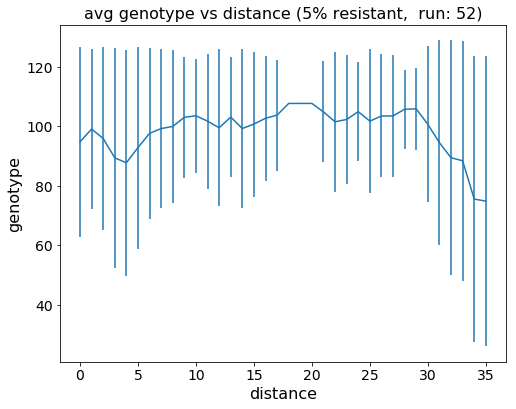

In [42]:
plotAvgGenoVsDistance(geno_dict, runID, percent, date)

In [43]:
#def plotGenoDistbVsTimeAndAvgGenoVsDistanceSideBySide(geno_dict, run_counters, runID, percent, date):
    

In [44]:
def printMostAndLeastReplicationsRunIDs(all_counters):
    
    replications_dict = {runID:int(all_counters[runID]['n_replications']) for runID in all_counters}
    #print(replications_dict)
    reps_sorted = Counter(replications_dict).most_common()
    
    print("runs with the most replications")
    print(reps_sorted[:5])
    
    print("\nruns with the least replications")
    print(reps_sorted[-5:][::-1])
    print()
    
    thickness_dict = Counter({runID:int(all_counters[runID]['bf thickness']) for runID in all_counters}).most_common()
    grown_dicts = {}
    n_thicks = 0
    for key, value in thickness_dict:
        if value > 0:
            grown_dicts[key] = value
    
    
    print(len(grown_dicts))
    print(grown_dicts)
    
    
printMostAndLeastReplicationsRunIDs(all_counters)

runs with the most replications
[('run_ID = 105', 249685), ('run_ID = 86', 244143), ('run_ID = 14', 211073), ('run_ID = 52', 204646), ('run_ID = 179', 187899)]

runs with the least replications
[('run_ID = 36', 3265), ('run_ID = 8', 4482), ('run_ID = 68', 5087), ('run_ID = 88', 6177), ('run_ID = 121', 6200)]

189
{'run_ID = 105': 45, 'run_ID = 86': 44, 'run_ID = 135': 40, 'run_ID = 179': 39, 'run_ID = 14': 37, 'run_ID = 166': 37, 'run_ID = 52': 35, 'run_ID = 62': 35, 'run_ID = 111': 34, 'run_ID = 134': 34, 'run_ID = 124': 32, 'run_ID = 162': 32, 'run_ID = 171': 32, 'run_ID = 71': 31, 'run_ID = 97': 31, 'run_ID = 157': 31, 'run_ID = 198': 31, 'run_ID = 26': 30, 'run_ID = 186': 30, 'run_ID = 187': 30, 'run_ID = 31': 29, 'run_ID = 137': 28, 'run_ID = 23': 27, 'run_ID = 58': 27, 'run_ID = 108': 27, 'run_ID = 127': 27, 'run_ID = 46': 26, 'run_ID = 60': 26, 'run_ID = 93': 26, 'run_ID = 95': 26, 'run_ID = 176': 26, 'run_ID = 196': 26, 'run_ID = 70': 25, 'run_ID = 78': 25, 'run_ID = 119': 25, 

In [45]:
def getAllAvgGenosOverTime(percent, date):
    '''this gets dicts of all the genos in each microhabitat over time for all the runs in a given 
    date directory (all 200ish runs). it then returns a list of lists, containing for each run: the average genotype 
    of the whole system for each time measurement
    
    returns: list of tuples, [(runId, [times], [avgGenoDistb], [genoStDevs]) for run in directory]'''
    
    N = 101 #this is the length that all the lists SHOULD be. if it's less than this then the list gets padded with None
    
    runID_and_genosOverTime = []
    
    directory_string = 'counters_data/all_run_populations-'+str(percent)+'_suscep'+str(date)
    directory = os.fsencode(directory_string)
    
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if 'event_counters' not in filename:
            
            runID = str(int(float(re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", filename)[-1])))
            geno_dict = getDictOfPopDistbsAtEachTime_filename(directory_string+'/'+filename)
            chronological_genos = OrderedDict(sorted(geno_dict.items(), key=lambda s: float(s[0].split('=')[1])))
            
            times = []
            avg_genos_over_time = []
            geno_stDev_over_time = []
            
            for tk in chronological_genos.keys():
                
                times.append(float(re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", tk)[-1]))
                list_of_all_bacteria = []
                avg_system_geno = 0. #sum used for the average genotype
                n_bacteria = 0 #
                
                for mh_k in chronological_genos[tk].keys():
                    
                    if len(chronological_genos[tk][mh_k])>0:
                        list_of_all_bacteria.extend(chronological_genos[tk][mh_k])
                        avg_system_geno += sum(chronological_genos[tk][mh_k])
                        n_bacteria += len(chronological_genos[tk][mh_k])
                
                if(n_bacteria > 0 and n_bacteria < 2):

                    avg_genos_over_time.append(statistics.mean(list_of_all_bacteria))
                    geno_stDev_over_time.append(0.)
                    
                elif(n_bacteria >= 2):
                    
                    avg_genos_over_time.append(statistics.mean(list_of_all_bacteria))
                    geno_stDev_over_time.append(statistics.stdev(list_of_all_bacteria))
                    
                else:
                    avg_genos_over_time.append(0.)
                    geno_stDev_over_time.append(0.)
                
            if(len(times)<101):
                times += [None]*(N-len(times))
                avg_genos_over_time += [None]*(N-len(avg_genos_over_time))
                geno_stDev_over_time += [None]*(N-len(geno_stDev_over_time))
                
            runID_and_genosOverTime.append((runID, times, avg_genos_over_time, geno_stDev_over_time))
            
    return runID_and_genosOverTime
     
    
#getAllAvgGenosOverTime(99, '-20-August-2019')

In [46]:
def getAllAvgGenosOverTime_v2(percent, dates, runID_padder):
    '''this is an upgraded version of the pervious version.  it allows for simulations performed on different
    dates to be collated
    
    this gets dicts of all the genos in each microhabitat over time for all the runs in a given 
    date directory (all 200ish runs). it then returns a list of lists, containing for each run: the average genotype 
    of the whole system for each time measurement
    
    returns: list of tuples, [(runId, [times], [avgGenoDistb], [genoStDevs]) for run in directory]'''
    runID_and_genosOverTime = []
    for i in range(len(dates)):
        N = 101 #this is the length that all the lists SHOULD be. if it's less than this then the list gets padded with None
    
        

        directory_string = 'counters_data/all_run_populations-'+str(percent)+'_suscep'+str(dates[i])
        directory = os.fsencode(directory_string)

        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if 'event_counters' not in filename:

                #here we need to pad the runIDs again, for inclusion in the legend
                regex_string = "[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?"
                runID_number = int(float(re.findall(regex_string, filename)[-1]))+runID_padder[i]
                runID = str(runID_number)
                geno_dict = getDictOfPopDistbsAtEachTime_filename(directory_string+'/'+filename)
                chronological_genos = OrderedDict(sorted(geno_dict.items(), key=lambda s: float(s[0].split('=')[1])))

                times = []
                avg_genos_over_time = []
                geno_stDev_over_time = []

                for tk in chronological_genos.keys():

                    times.append(float(re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", tk)[-1]))
                    list_of_all_bacteria = []
                    avg_system_geno = 0. #sum used for the average genotype
                    n_bacteria = 0 #

                    for mh_k in chronological_genos[tk].keys():

                        if len(chronological_genos[tk][mh_k])>0:
                            list_of_all_bacteria.extend(chronological_genos[tk][mh_k])
                            avg_system_geno += sum(chronological_genos[tk][mh_k])
                            n_bacteria += len(chronological_genos[tk][mh_k])

                    if(n_bacteria > 0 and n_bacteria < 2):

                        avg_genos_over_time.append(statistics.mean(list_of_all_bacteria))
                        geno_stDev_over_time.append(0.)

                    elif(n_bacteria >= 2):

                        avg_genos_over_time.append(statistics.mean(list_of_all_bacteria))
                        geno_stDev_over_time.append(statistics.stdev(list_of_all_bacteria))

                    else:
                        avg_genos_over_time.append(0.)
                        geno_stDev_over_time.append(0.)

                if(len(times)<101):
                    times += [None]*(N-len(times))
                    avg_genos_over_time += [None]*(N-len(avg_genos_over_time))
                    geno_stDev_over_time += [None]*(N-len(geno_stDev_over_time))

                runID_and_genosOverTime.append((runID, times, avg_genos_over_time, geno_stDev_over_time))
            
    return runID_and_genosOverTime

In [47]:
def selectRunsWithCriteria(all_run_counters, criteria_key, criteria_value):
    '''this selects all runs which satisfy a given criteria, e.g. thickness > 0'''
    selected_runs = []
    for runID in all_run_counters.keys():
        #here we select all runs that have a thickness 
        if all_run_counters[runID][criteria_key] > criteria_value:
            selected_runs.append((str(re.search(r'\d+', runID).group()), all_run_counters[runID][criteria_key], all_run_counters[runID]['n_replications']))
            #print(runID+", "+str(all_run_counters[runID]['bf thickness'])+', '+str(all_run_counters[runID]['n_replications']))
    
    sorted_selection = sorted(selected_runs, key = operator.itemgetter(1, 2))[::-1]
    #return [str(x[0]) for x in sorted_selection]
    return sorted_selection
    
x=selectRunsWithCriteria(eventCounters_95pc_20Aug2019, 'bf thickness', 20)   

400


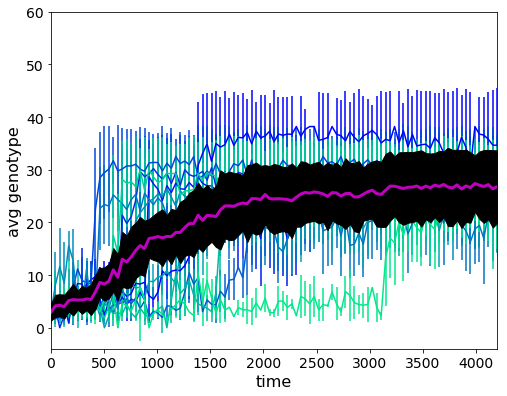

200


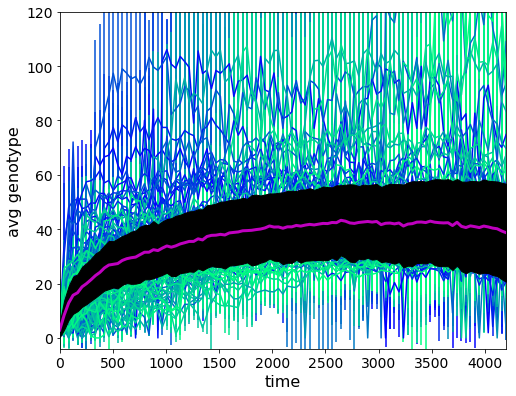

200


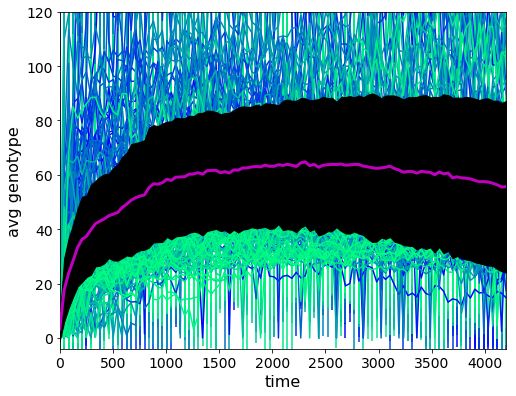

In [48]:
def plotAllAvgGenosOverTime(percent, dates, all_run_counters, runID_padders, criteria_label, criteria_val, y_max):
    '''this takes all the runs for a given resistance distb, and plots the average genotype of the whole system
    over time for each run on a graph'''
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    percent_res = 100 - percent
    
    
    #geno_data_triplets = getAllAvgGenosOverTime_v2(percent, dates, runID_padders) #change to quadruplets
    geno_data_triplets = getAvgEdgeGenosOverTime(percent, dates, runID_padders)
    runIDs, t, avg_genos, geno_stDevs = list(zip(*geno_data_triplets))
    print(len(runIDs))
    runs_to_plot, thickness, replications = list(zip(*selectRunsWithCriteria(all_run_counters, criteria_label, criteria_val)))
    
    selected_run_genos = []
    selected_run_geno_stDev = []
    n_lines = 0
    
    for selected_run in runs_to_plot:
        if selected_run in runIDs:
            i = runIDs.index(selected_run)
            colour = plt.cm.winter(n_lines/float(len(runs_to_plot))) #this selects a colour to make the line
            #ax.plot(t[i], avg_genos[i], label=runIDs[i], color=colour)
            #convert them to numpy arrays here so then don't plot the nans
            t_arr = np.array(t[i], dtype=np.float)
            avg_geno_arr = np.array(avg_genos[i], dtype=np.float)
            geno_stDev_arr = np.array(geno_stDevs[i], dtype=np.float)
            
            ax.errorbar(t_arr, avg_geno_arr, yerr=geno_stDev_arr,label=runIDs[i], color=colour)
            n_lines+=1
            
            #add the selected run data to a master list here, for analysis later
            selected_run_genos.append(avg_geno_arr)
            selected_run_geno_stDev.append(geno_stDev_arr)
    
    #print(selected_run_genos[0])
    overall_avg_genos = np.nanmean(selected_run_genos, axis=0)
    overall_geno_stDev = np.nanmean(selected_run_geno_stDev, axis=0)
    
    #ax.errorbar(np.array(t[-1]), overall_avg_genos, yerr=overall_geno_stDev, color='k', linewidth=3, zorder=n_lines+1)
    ax.plot(np.array(t[-1]), overall_avg_genos, color='m', linewidth=3, zorder=n_lines+1)
    ax.fill_between(np.array(t[-1]), overall_avg_genos-overall_geno_stDev, overall_avg_genos+overall_geno_stDev, color='k', zorder=n_lines+1)        

    
    ax.set_ylim(-4, y_max)
    ax.set_xlim(0, 4200)
    ax.set_xlabel('time', fontsize=labelSize)
    ax.set_ylabel('avg genotype', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    n_cols = int(math.ceil(n_lines/12.))
    #plt.legend(loc='upper left', bbox_to_anchor=(1.02,1.), fontsize='large', ncol=n_cols)
    plt.savefig("counters_plots/all_edge_genos_"+str(percent)+"res.pdf", bbox_inches='tight')
    plt.show()
        
    
#     for runID, t, avg_geno in geno_data_triplets:
#         if all(g > 10 for g in avg_geno[17:]):
#             ax.plot(t, avg_geno)


plotAllAvgGenosOverTime(99, dates, eventCounters_99pc_ALL, runID_padders_99pc, 'bf thickness', 2, 60)
plotAllAvgGenosOverTime(95, ['-20-August-2019'], eventCounters_95pc_20Aug2019, runID_padders_95pc, 'bf thickness', 10, 120)
plotAllAvgGenosOverTime(90, ['-20-August-2019'], eventCounters_90pc_20Aug2019, runID_padders_90pc, 'bf thickness', 10, 120)

In [49]:
def getAvgEdgeGenosOverTime(percent, dates, runID_padder):
    '''
    this version gets dicts of all the genos in the edge habitat (habitat furthest from the hull) and calcuates 
    the average genotype and its standard deviation. does this for all the runs in the supplied directories
   
    
    returns: list of tuples, [(runId, [times], [avgGenoDistb], [genoStDevs]) for run in directory]'''
    runID_and_genosOverTime = []
    
    for i in range(len(dates)):
        N = 101 #this is the length that all the lists SHOULD be. if it's less than this then the list gets padded with None
    
        

        directory_string = 'counters_data/all_run_populations-'+str(percent)+'_suscep'+str(dates[i])
        directory = os.fsencode(directory_string)

        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if 'event_counters' not in filename:

                #here we need to pad the runIDs again, for inclusion in the legend
                regex_string = "[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?"
                runID_number = int(float(re.findall(regex_string, filename)[-1]))+runID_padder[i]
                runID = str(runID_number)
                geno_dict = getDictOfPopDistbsAtEachTime_filename(directory_string+'/'+filename)
                #this organises the dict so that the time keys are in chronological order
                chronological_genos = OrderedDict(sorted(geno_dict.items(), key=lambda s: float(s[0].split('=')[1])))

                times = []
                avg_genos_over_time = []
                geno_stDev_over_time = []

                for tk in chronological_genos.keys():
                    
                    times.append(float(re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", tk)[-1]))
                    
                    #sort the microhabitat indexes by numeric value
                    spatial_sorted_genos = OrderedDict(sorted(chronological_genos[tk].items(), key = lambda mh: int(mh[0].split('=')[1])))
                    avg_edge_geno = 0. #sum used for the average genotype
                    n_bacteria = 0 #
                    
                    edge_mh_key = next(reversed(spatial_sorted_genos))
                    #print(runID+"\t"+edge_mh_key)
                    edge_mh = spatial_sorted_genos[edge_mh_key]
                    
                    n_bacteria = len(edge_mh)
                    
                    if(n_bacteria > 0 and n_bacteria < 2):

                        avg_genos_over_time.append(statistics.mean(edge_mh))
                        geno_stDev_over_time.append(0.)

                    elif(n_bacteria >= 2):

                        avg_genos_over_time.append(statistics.mean(edge_mh))
                        geno_stDev_over_time.append(statistics.stdev(edge_mh))

                    else:
                        avg_genos_over_time.append(0.)
                        geno_stDev_over_time.append(0.)
                    


                if(len(times)<101):
                    times += [None]*(N-len(times))
                    avg_genos_over_time += [None]*(N-len(avg_genos_over_time))
                    geno_stDev_over_time += [None]*(N-len(geno_stDev_over_time))

                runID_and_genosOverTime.append((runID, times, avg_genos_over_time, geno_stDev_over_time))
            
    return runID_and_genosOverTime

#test = getAvgEdgeGenosOverTime(95, ['-20-August-2019'], runID_padders_95pc)
#print(test)

In [50]:
def getSystemThicknessOverTime(percent, dates, runID_padder):
    '''this method iterates through all the runs and gets the system thicknesses as a function of time
    
    returns [(runID, [times], [thicknesses(t)])], where each index is a triplet containing these things
    '''
    
    runID_and_ThicknessOverTime = []
    
    for i in range(len(dates)):
        N = 101 #this is the length that all the lists SHOULD be. if it's less than this then the list gets padded with None
    
        

        directory_string = 'counters_data/all_run_populations-'+str(percent)+'_suscep'+str(dates[i])
        directory = os.fsencode(directory_string)

        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if 'event_counters' not in filename:

                #here we need to pad the runIDs again, for inclusion in the legend
                regex_string = "[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?"
                runID_number = int(float(re.findall(regex_string, filename)[-1]))+runID_padder[i]
                runID = str(runID_number)
                geno_dict = getDictOfPopDistbsAtEachTime_filename(directory_string+'/'+filename)
                chronological_genos = OrderedDict(sorted(geno_dict.items(), key=lambda s: float(s[0].split('=')[1])))

                times = []
                thickness_over_time = []

                for tk in chronological_genos.keys():

                    times.append(float(re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", tk)[-1]))
                    thickness_over_time.append(len(chronological_genos[tk]) - 1)

                    
                if(len(times)<101):
                    times += [None]*(N-len(times))
                    thickness_over_time += [None]*(N-len(thickness_over_time))
                    

                runID_and_ThicknessOverTime.append((runID, times, thickness_over_time))
            
    return runID_and_ThicknessOverTime


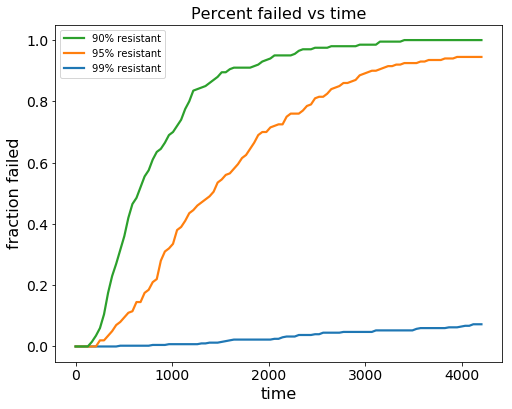

In [51]:
def plotTimeToFailure(percent, dates, runID_padders):
    
    '''at each timestep, plot the number of runs which have a thickness greater than 1 (might change this criteria later)
    need to iterate through each run.  have a list which contains the counts for each timestep. call it thick_counts. thick_counts[i]
     corresponds to time[i].
    '''
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    percent_res = 100 - percent
    
    percents = [99, 95, 90]
    date_list = [dates, dates[:1], dates[:1]]
    runID_padders = [runID_padders_99pc, runID_padders_95pc, runID_padders_90pc]
    
    for pc_i in range(len(percents)):
        
    
        geno_thickness_triplets = getSystemThicknessOverTime(percents[pc_i], date_list[pc_i], runID_padders[pc_i])
        runIDs, t, thicknesses = list(zip(*geno_thickness_triplets))
        thick_counts = [0.]*len(t[0]) #initialise list as long as the no. of timestep

        for i in range(len(runIDs)):
            for j in range(len(thicknesses[i])):

                if thicknesses[i][j] > 0:
                    thick_counts = thick_counts[:j] + [count+1 for count in thick_counts[j:]]
                    break
                
    
        #print(len(runIDs))
        thick_counts = [c/len(runIDs) if c > 0 else c for c in thick_counts]

        ax.plot(t[0], thick_counts, label=str(percents[pc_i])+"% resistant", linewidth=2.2)
        
        
        
    ax.set_title('Percent failed vs time', fontsize=titleSize)
    ax.set_xlabel('time', fontsize=labelSize)
    ax.set_ylabel('fraction failed', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    plt.savefig('counters_plots/time_to_failure.pdf', bbox_inches='tight')
    plt.show()
            
    
        

plotTimeToFailure(99, dates, runID_padders_99pc)

400


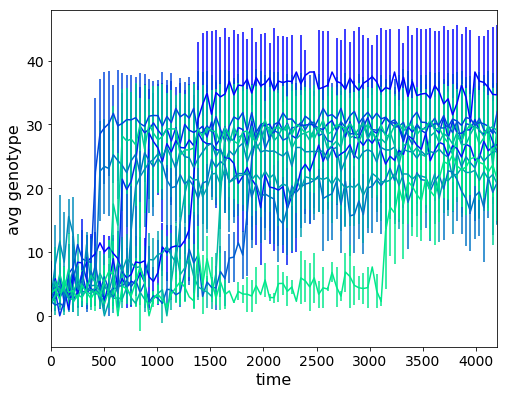

200


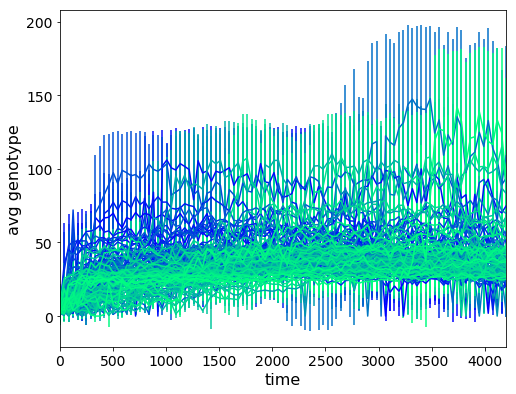

200


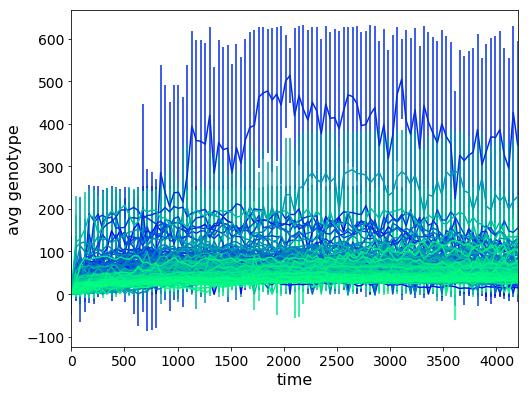

In [52]:
def plotAllAvgGenosOverTime_noTotalAverage(percent, dates, all_run_counters, runID_padders, criteria_label, criteria_val, y_max):
    '''this takes all the runs for a given resistance distb, and plots the average genotype of the whole system
    over time for each run on a graph'''
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    percent_res = 100 - percent
    
    
    #geno_data_triplets = getAllAvgGenosOverTime_v2(percent, dates, runID_padders) #change to quadruplets
    geno_data_triplets = getAvgEdgeGenosOverTime(percent, dates, runID_padders)
    runIDs, t, avg_genos, geno_stDevs = list(zip(*geno_data_triplets))
    print(len(runIDs))
    runs_to_plot, thickness, replications = list(zip(*selectRunsWithCriteria(all_run_counters, criteria_label, criteria_val)))
    
    selected_run_genos = []
    selected_run_geno_stDev = []
    n_lines = 0
    
    for selected_run in runs_to_plot:
        if selected_run in runIDs:
            i = runIDs.index(selected_run)
            colour = plt.cm.winter(n_lines/float(len(runs_to_plot))) #this selects a colour to make the line
            #ax.plot(t[i], avg_genos[i], label=runIDs[i], color=colour)
            #convert them to numpy arrays here so then don't plot the nans
            t_arr = np.array(t[i], dtype=np.float)
            avg_geno_arr = np.array(avg_genos[i], dtype=np.float)
            geno_stDev_arr = np.array(geno_stDevs[i], dtype=np.float)
            
            ax.errorbar(t_arr, avg_geno_arr, yerr=geno_stDev_arr,label=runIDs[i], color=colour)
            n_lines+=1
            
            #add the selected run data to a master list here, for analysis later
            selected_run_genos.append(avg_geno_arr)
            selected_run_geno_stDev.append(geno_stDev_arr)
    
    #print(selected_run_genos[0])
    overall_avg_genos = np.nanmean(selected_run_genos, axis=0)
    overall_geno_stDev = np.nanmean(selected_run_geno_stDev, axis=0)
    
    #ax.errorbar(np.array(t[-1]), overall_avg_genos, yerr=overall_geno_stDev, color='k', linewidth=3, zorder=n_lines+1)
#     ax.plot(np.array(t[-1]), overall_avg_genos, color='m', linewidth=3, zorder=n_lines+1)
#     ax.fill_between(np.array(t[-1]), overall_avg_genos-overall_geno_stDev, overall_avg_genos+overall_geno_stDev, color='k', zorder=n_lines+1)        

    
    #ax.set_ylim(-4, y_max)
    ax.set_xlim(0, 4200)
    ax.set_xlabel('time', fontsize=labelSize)
    ax.set_ylabel('avg genotype', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    n_cols = int(math.ceil(n_lines/12.))
    #plt.legend(loc='upper left', bbox_to_anchor=(1.02,1.), fontsize='large', ncol=n_cols)
    plt.savefig("counters_plots/all_edge_genos_"+str(percent)+"res_noAvg.pdf", bbox_inches='tight')
    plt.show()
    
plotAllAvgGenosOverTime_noTotalAverage(99, dates, eventCounters_99pc_ALL, runID_padders_99pc, 'bf thickness', 2, 60)
plotAllAvgGenosOverTime_noTotalAverage(95, ['-20-August-2019'], eventCounters_95pc_20Aug2019, runID_padders_95pc, 'bf thickness', 10, 120)
plotAllAvgGenosOverTime_noTotalAverage(90, ['-20-August-2019'], eventCounters_90pc_20Aug2019, runID_padders_90pc, 'bf thickness', 10, 120)